# Keras ResNet Deep Neural Network for Hand Sign Image Recognition 

In this notebook , I am building a Hand Sign Recognition system with ResNet using Keras . Hand Sign means numeric signs (e.g. 0,1,2,3,4,5) using our hand . We have built a deep learning neural network to accomplish our target . We are using Keras deep learning framework . 

In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import h5py
import time
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

hand-sign
hand-sign-test



The Hand sign data set that we will use is available in .h5 format . So, we use h5py package we load the data . Then we convert the data in numpy array . Each image is a 3 channel image with 64 * 64  dimension. There are 1080 images in the train data and 120 in test data. 

In [19]:
def load_dataset():
    train_dataset = h5py.File('../input/hand-sign/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('../input/hand-sign-test/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    #classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig,test_set_x_orig,test_set_y_orig

Load the data and have quick look at rhe shape of the data.

In [20]:
train_x,train_y,test_x,test_y = load_dataset()
train_x.shape,train_y.shape,test_x.shape,test_y.shape

((1080, 64, 64, 3), (1, 1080), (120, 64, 64, 3), (1, 120))

In [21]:
train_y = train_y.reshape((1080,))
test_y = test_y.reshape((120,))
Y_train = np.zeros([1080,6])
count = 0
for i in train_y:
    Y_train[count,i] = 1
    count = count+1
Y_test = np.zeros([120,6])
count = 0
for  i in test_y:
    Y_test[count,i] = 1
    count = count+1

Just to have a look at how the images look like we use matplotlib.pyplot.imshow to display 2 imges from training data and 2 from test data.

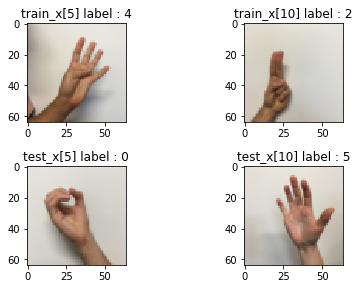

In [22]:
import matplotlib.pyplot as plt
plt.subplots(2,2)
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.45,
                    wspace=0.45)

plt.subplot(2,2,1)
plt.title('train_x[5] label : 4')
plt.imshow(train_x[5])
plt.subplot(2,2,2)
plt.title('train_x[10] label : 2')
plt.imshow(train_x[10])

plt.subplot(2,2,3)
plt.title('test_x[5] label : 0')
plt.imshow(test_x[5])
plt.subplot(2,2,4)
plt.title('test_x[10] label : 5')
plt.imshow(test_x[10])


Importing all keras libraries required for our Deep NN model.

In [23]:
from keras import layers
from keras.layers import Input,Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.initializers import glorot_uniform

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

import keras.backend as K
K.set_image_data_format('channels_last')

So, as we will be building a small ResNet(i.e. Residual Network) . And for this purpose we need to first build two methods. one is plain_layer ,which is just a combination of Conv2D , BatchNorm, Relu and MaxPooling2D . Other is identity_block which is the Residual block.
![alt text](https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/resnets_1.png 'Logo Title Text 1')

In [24]:
def plain_layer(X,n_c):
    X_in = X
    X = Conv2D(n_c,kernel_size=(3,3),padding='same')(X_in)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size=(2,2))(X)
    
    return X

The Residual block that I am using looks like this .
![alt text](https://github.com/ayanmaity201/Hand-Sign-DeepNN/blob/master/convblock_image.png?raw=true)

In [25]:
def identity_block(X,F):
    X_in = X
    
    F1,F2,F3 = F
    
    X = Conv2D(F1,kernel_size=(3,3),padding='same')(X_in)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    
    X = Conv2D(F2,kernel_size=(3,3),padding='same')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    
    X = Conv2D(F3,kernel_size=(3,3),padding='same')(X)
    X = BatchNormalization(axis=3)(X)
    
    X_in = Conv2D(F3,kernel_size=(3,3),padding='same')(X_in)
    X_in = BatchNormalization(axis=3)(X_in)
    
    X = Add()([X,X_in])
    X = Activation('relu')(X)
    
    return X

Now we put all the building blocks together to form the ResNet model . Here I am using one plain_layer followed by three similar looking identity_block. Then we add the Flatten lyer and 3 Dense layers. 

In [26]:
def Resnet(input_shape=(64,64,3),classes=6):
    X_in = Input(input_shape)
    
    X = plain_layer(X_in,32)
    
    F1 = [16,16,32]
    X = identity_block(X,F1)
    
    F2 = [16,16,32]
    X = identity_block(X,F2)
    
    F3 = [16,16,32]
    X = identity_block(X,F3)
   
    X = AveragePooling2D((2,2))(X)
    
    X = Flatten()(X)
    X = Dense(512,activation='relu')(X)
    X = Dense(128,activation='relu')(X)
    X = Dense(classes,activation='softmax')(X)
    
    model = Model(inputs=X_in,outputs=X,name='Resnet')
    return model

We have to normalize the image data to geta better result in training. 

In [27]:
X_train = train_x/255
X_test = test_x/255

In [30]:
my_model = Resnet()

I am using 'sgd' optimizer with default parameters and 'categorical_crossentropy' loss function and then we fit the model  with  data with batch size of 32 for 20 epochs. 

In [31]:
my_model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])
my_model.fit(x=X_train,y=Y_train,epochs=20,batch_size=32)
time.sleep(5)

Epoch 1/20
1080/1080 [==============================] - 49s 45ms/step - loss: 1.3785 - acc: 0.4630
Epoch 2/20
1080/1080 [==============================] - 48s 44ms/step - loss: 0.6484 - acc: 0.7694
Epoch 3/20
1080/1080 [==============================] - 48s 44ms/step - loss: 0.2958 - acc: 0.9176
Epoch 4/20
1080/1080 [==============================] - 47s 44ms/step - loss: 0.1578 - acc: 0.9639
Epoch 5/20
1080/1080 [==============================] - 48s 45ms/step - loss: 0.0817 - acc: 0.9954
Epoch 6/20
1080/1080 [==============================] - 47s 44ms/step - loss: 0.0583 - acc: 0.9935
Epoch 7/20
1080/1080 [==============================] - 47s 44ms/step - loss: 0.0345 - acc: 1.0000
Epoch 8/20
1080/1080 [==============================] - 48s 45ms/step - loss: 0.0259 - acc: 1.0000
Epoch 9/20
1080/1080 [==============================] - 47s 44ms/step - loss: 0.0209 - acc: 1.0000
Epoch 10/20
1080/1080 [==============================] - 48s 44ms/step - loss: 0.0167 - acc: 1.0000
Epoch 11/

When we evaluate the model on the training data , we get a 100 % accuracy . 

In [32]:
my_model.evaluate(X_train,Y_train,batch_size=32)

1080/1080 [==============================] - 16s 15ms/step


[0.020185805222502462, 1.0]

In [ ]:
my_model.save('my_model.h5')

Now we evaluate the model on test data. And this small ResNet gets an accuracy of 96.67 % . That is best compared to other Deep NN I tried on this data. 

In [33]:
my_model.evaluate(X_test,Y_test,batch_size=32)

120/120 [==============================] - 2s 16ms/step


[0.15168693860371907, 0.9666666626930237]

Classification Report for the test data .

In [35]:
from sklearn.metrics import classification_report
pred = my_model.predict(X_test)
pred_label = np.argmax(pred,axis=1)
print(classification_report(test_y,pred_label))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        20
          1       0.91      1.00      0.95        20
          2       0.95      0.90      0.92        20
          3       0.95      1.00      0.98        20
          4       1.00      0.90      0.95        20
          5       1.00      1.00      1.00        20

avg / total       0.97      0.97      0.97       120



So, Finally we see how to build a simple ResNet model on keras and We see the power of ResNet model in this notebook.